### Model 2.1: Bayesian spatial hierarchical model with GP prior on NAPRS dataset

In [1]:
import pandas as pd
import numpy as np
import nibabel as nib
from model.utils import save_pickle, load_pickle
from model.helper import scale
from nilearn.plotting import plot_stat_map
import matplotlib.pyplot as plt
import torch
import importlib
from model.helper import matern_kernel, ker_approx


In [2]:
### template
data_path = 'data/NARPS'
mni_img = nib.load(f'{data_path}/group_analysis.ttest.1grp.equalRange.gain/MNI152_2009_template_SSW.nii.gz')
mni_data = mni_img.get_fdata()[:, :, :, 0, 0]  # Extract the 0-th volume
target_affine = mni_img.affine
x,y,z=(mni_data).nonzero()

### mask
mask_path = f'{data_path}/group_analysis.ttest.1grp.equalRange.gain/group_mask.inter.nii.gz'
mask_img = nib.Nifti1Image.from_filename(mask_path)
mask = nib.Nifti1Image.from_filename(mask_path).get_fdata()

In [3]:
### load data
narps = load_pickle('data/NARPS/data.pickle')
data = narps['data']
x,y,z = narps['coord']
S = narps['S']
N, V = data.shape
dtype = torch.float32

Pickle loaded from data/NARPS/data.pickle


In [4]:
from sklearn.gaussian_process.kernels import RBF, Matern
### choose kernel function
ls = 0.1
# kernel = RBF(length_scale=ls)
kernel = Matern(length_scale=ls, nu=1.5)

In [5]:
import model.BSHE_GP as BSHE_GP
BSHE_GP = importlib.reload(BSHE_GP) 

In [6]:
n_chain=3
L = 1200 #number of basis function used to approximate GP kernel (tuning parameter)

In [7]:
### precompute basis approximation for GP kernel function
B, eig_val_sqrt = BSHE_GP.get_basis(S, L,  kernel, dtype=dtype)

KeyboardInterrupt: 

In [ ]:
basis =  B * (eig_val_sqrt.unsqueeze(0))

In [ ]:
samples = BSHE_GP.run_multiple_chains(
    Y=data,
    n_chains=n_chain, seeds = 42, 
    grids=S, kernel=kernel, L = L,
    B = B, eig_val_sqrt=eig_val_sqrt,
    burnin=3000,
    mcmc_sample=500,
    thin=2,
    dtype=dtype,
    parallel=False,
)


100%|██████████| 3000/3000 [00:45<00:00, 66.02it/s]


Chain 1 finished in 45.46 seconds


100%|██████████| 3000/3000 [00:43<00:00, 69.67it/s]


Chain 2 finished in 43.06 seconds


100%|██████████| 3000/3000 [00:43<00:00, 68.34it/s]


Chain 3 finished in 43.90 seconds


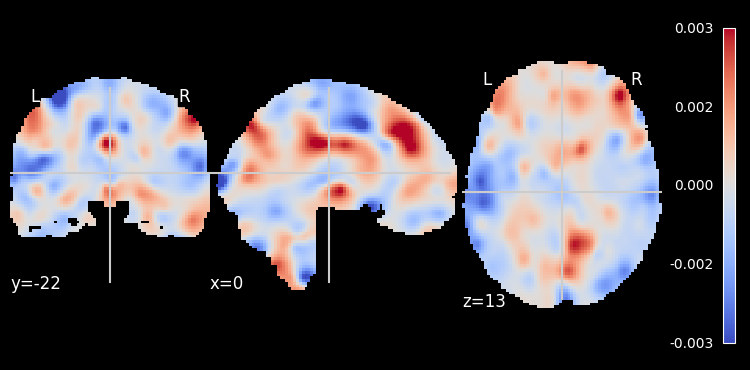

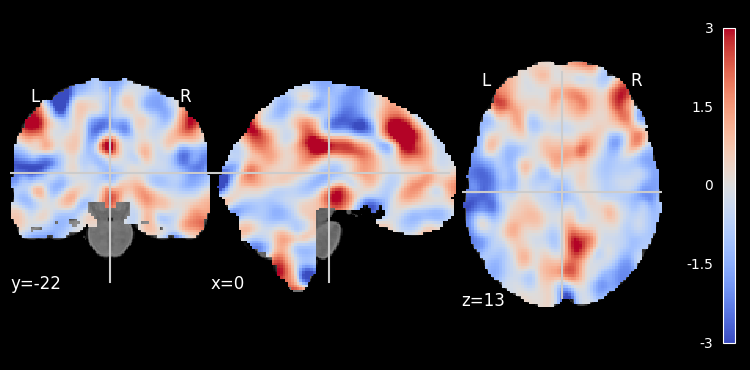

In [10]:
voxel_mcmc = samples['alpha'][:,:,None] + samples['theta_beta'] @ basis.t()
mean = voxel_mcmc.mean(dim=(0,1))
std = voxel_mcmc.std(dim=(0,1))
z_score = mean / std
post_map = np.zeros(mask_img.shape)
post_map[x, y, z] = mean
post_map_img = nib.Nifti1Image(post_map, mask_img.affine)
fig=plot_stat_map(post_map_img,
                bg_img=nib.Nifti1Image(mask, mask_img.affine),
                colorbar=True,
                threshold=0,
                cbar_tick_format="%.3f",
                vmax=0.003, vmin=-0.003,
                cmap='coolwarm',
                cut_coords=[0, -22, 13])
#fig.savefig('plots/voxel_m21_mean.png', dpi=300)

post_map = np.zeros(mask_img.shape)
post_map[x, y, z] =  mean / std
post_map_img = nib.Nifti1Image(post_map, mask_img.affine)
fig=plot_stat_map(post_map_img,
                bg_img=nib.Nifti1Image(mni_data, mni_img.affine),
                colorbar=True,
                threshold=0,
                vmax=3, vmin=-3,
                cmap='coolwarm',
                cut_coords=[0, -22, 13])
#fig.savefig('plots/voxel_m21_zscore.png', dpi=300)


In [ ]:
### save results
# post_map = np.zeros(mask_img.shape, dtype=np.float32)
# post_map[x, y, z] = mean.numpy().astype(np.float32)
# post_map_img = nib.Nifti1Image(post_map, affine=mask_img.affine, dtype=np.float32)
# post_map_img.header['qform_code'] = 4
# post_map_img.header['sform_code'] = 4
# nib.save(post_map_img, f"results/narps_M21_J{L}_posterior_mean.nii.gz")

In [12]:

# post_map = np.zeros(mask_img.shape, dtype=np.float32)
# post_map[x, y, z] = std.numpy().astype(np.float32)
# post_map_img = nib.Nifti1Image(post_map, affine=mask_img.affine)
# post_map_img.header['qform_code'] = 4
# post_map_img.header['sform_code'] = 4
# nib.save(post_map_img, f"results/narps_M21_J{L}_posterior_std.nii.gz")

In [13]:
ppc = BSHE_GP.PPC(data, samples, basis, n_samples=50)


In [14]:
ppc = ppc.reshape(-1, N, V) # flatten chains
ppc.shape

torch.Size([150, 47, 222230])

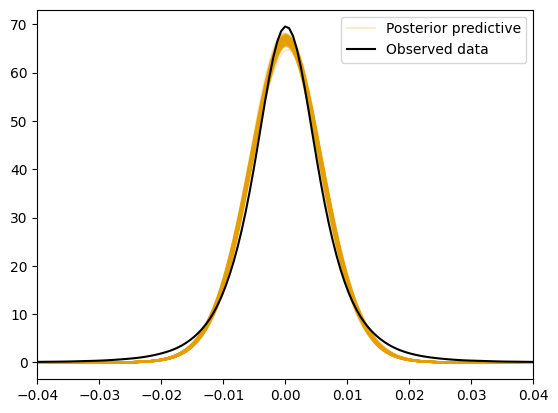

In [15]:
from fastkde import fastKDE
## takes about 9 mins for 300 draws
for i in range(ppc.shape[0]):
    density = fastKDE.pdf(ppc[i].reshape(-1),ecf_precision=1) # flat to vector
    density.plot(alpha=0.2, color="#E69F00", label='Posterior predictive' if i == 0 else None)
data_den= fastKDE.pdf(data.reshape(-1),ecf_precision=1)
data_den.plot(alpha=1.0, color="black", label='Observed data')
plt.xlim(-0.04, 0.04)  
plt.ylabel('')
plt.xlabel('')

# Add legend (only one entry for grey lines)
plt.legend()
#plt.savefig(f'plots/M21_ppc_L{L}.png', dpi=300, bbox_inches='tight')  
plt.show()